(105, 94, 163)
(105, 94)


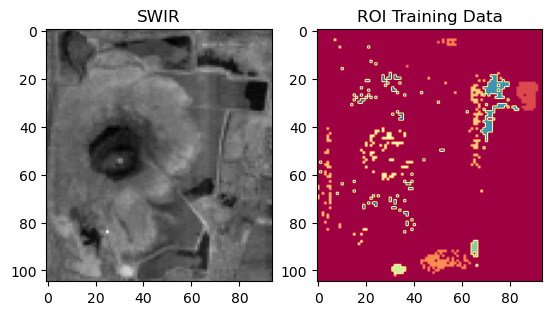

In [1]:
#CLAY MINERALS MAPPING IN SIDOARJO MUD VOLCANO USING RANDOM FOREST ALGORITHM AND HYPERION SATELLITE IMAGERY
#Erlang Dzarkhan Syah (19/443731/TK/48927)


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 1 IMPORT DATA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Memberi perintah pada GDAL untuk menggunakan exception dan register semua drivers
gdal.UseExceptions()
gdal.AllRegister()

# Baca data reflektansi permukaan dan ROI endmember
img_ds = gdal.Open(r"B:\SEMESTER 10\PENGERJAAN3\roi\destrip", gdal.GA_ReadOnly)
roi_ds = gdal.Open(r"B:\SEMESTER 10\PENGERJAAN 5\class image from roi\classimg\classimgfromroi", gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
print (img.shape)

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
print (roi.shape)

# Visualisasi
plt.subplot(121)
plt.imshow(img[:, :, 107], cmap=plt.cm.Greys_r)
plt.title('SWIR')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [3]:
# membaca berapa banyak sampel training data (berapa piksel yang terlibat sebagai training data)
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# membaca label untuk klasifikasi
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
print (labels)
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :] 
y = roi[roi > 0]

# Import the train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Training data size:', X_train.shape)
print('Testing data size:', X_test.shape)

# Now, we can use X_train and y_train for training your model,
# and X_test and y_test for testing its performance

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))
print (img.shape)

We have 607 samples
The training data include 8 classes: [1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8]
Training data size: (424, 163)
Testing data size: (183, 163)
Our X matrix is sized: (607, 163)
Our y array is sized: (607,)
After masking, our X matrix is sized: (607, 163)
After masking, our y array is sized: (607,)
(105, 94, 163)


Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.994535519125683
Confusion Matrix:
[[29  0  0  0  0  0  0  0]
 [ 0 33  0  0  0  0  0  1]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 31  0]
 [ 0  0  0  0  0  0  0 29]]
Kappa Score: 0.9935651745841978
Precision: 0.9947176684881602
Recall: 0.994535519125683
F1 Score: 0.9945410485776176
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        29
           2       1.00      0.97      0.99        34
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        31
           8       0.97      1.00   

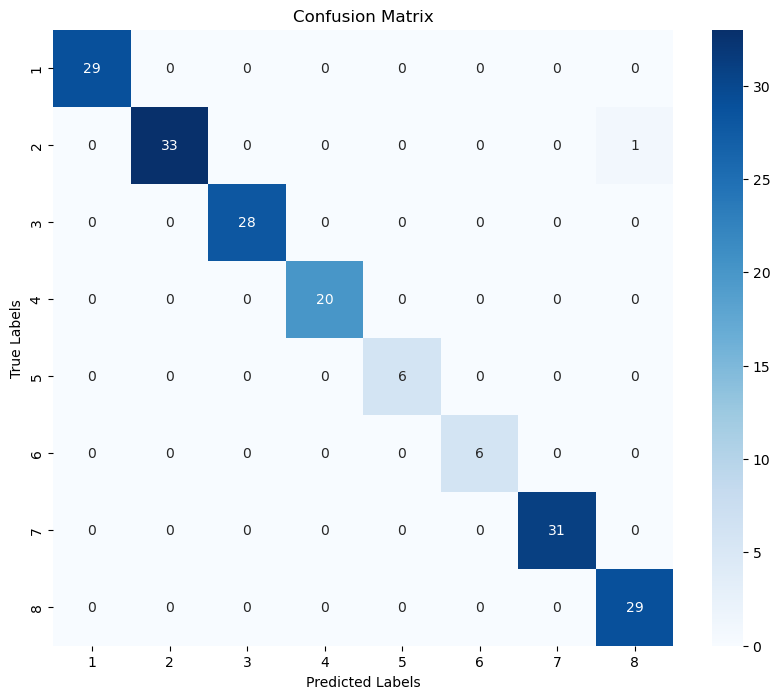

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 2 RANDOM FOREST ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score, precision_score, recall_score, f1_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42, oob_score = True)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best classifier on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Kappa score
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score:", kappa)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix as a heatmap using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_df = pd.DataFrame(conf_matrix, index=range(1, conf_matrix.shape[0] + 1),
                              columns=range(1, conf_matrix.shape[1] + 1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ BAND IMPORTANCE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import rasterio as rio

raster = r"B:\SEMESTER 10\PENGERJAAN3\roi\destrip"

with rio.open(raster) as image:
    bands = (image.read()).shape[0]

features = []
for i in range(bands):
    features.append('band'+str(i+1))

# Create a list of tuples containing band names and their corresponding importances
band_importances = [(b, imp) for b, imp in zip(features, best_rf_classifier.feature_importances_)]

for b, imp in band_importances:
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    


Band band1 importance: 0.0011708481214611937
Band band2 importance: 0.0033955839518076424
Band band3 importance: 0.0064613499294878425
Band band4 importance: 0.010941737642650304
Band band5 importance: 0.01908096335959396
Band band6 importance: 0.027680982107960547
Band band7 importance: 0.011553717067767437
Band band8 importance: 0.010471996952677875
Band band9 importance: 0.0107192300197568
Band band10 importance: 0.020926048705481887
Band band11 importance: 0.005893244268910342
Band band12 importance: 0.0036932627401843232
Band band13 importance: 0.00834625341797104
Band band14 importance: 0.010126886913777864
Band band15 importance: 0.012806892977940507
Band band16 importance: 0.0056055018661842594
Band band17 importance: 0.006558661866209051
Band band18 importance: 0.006641006107481503
Band band19 importance: 0.007698878926257167
Band band20 importance: 0.0071237321066472785
Band band21 importance: 0.0039584740232192364
Band band22 importance: 0.0035820032132854824
Band band23 imp

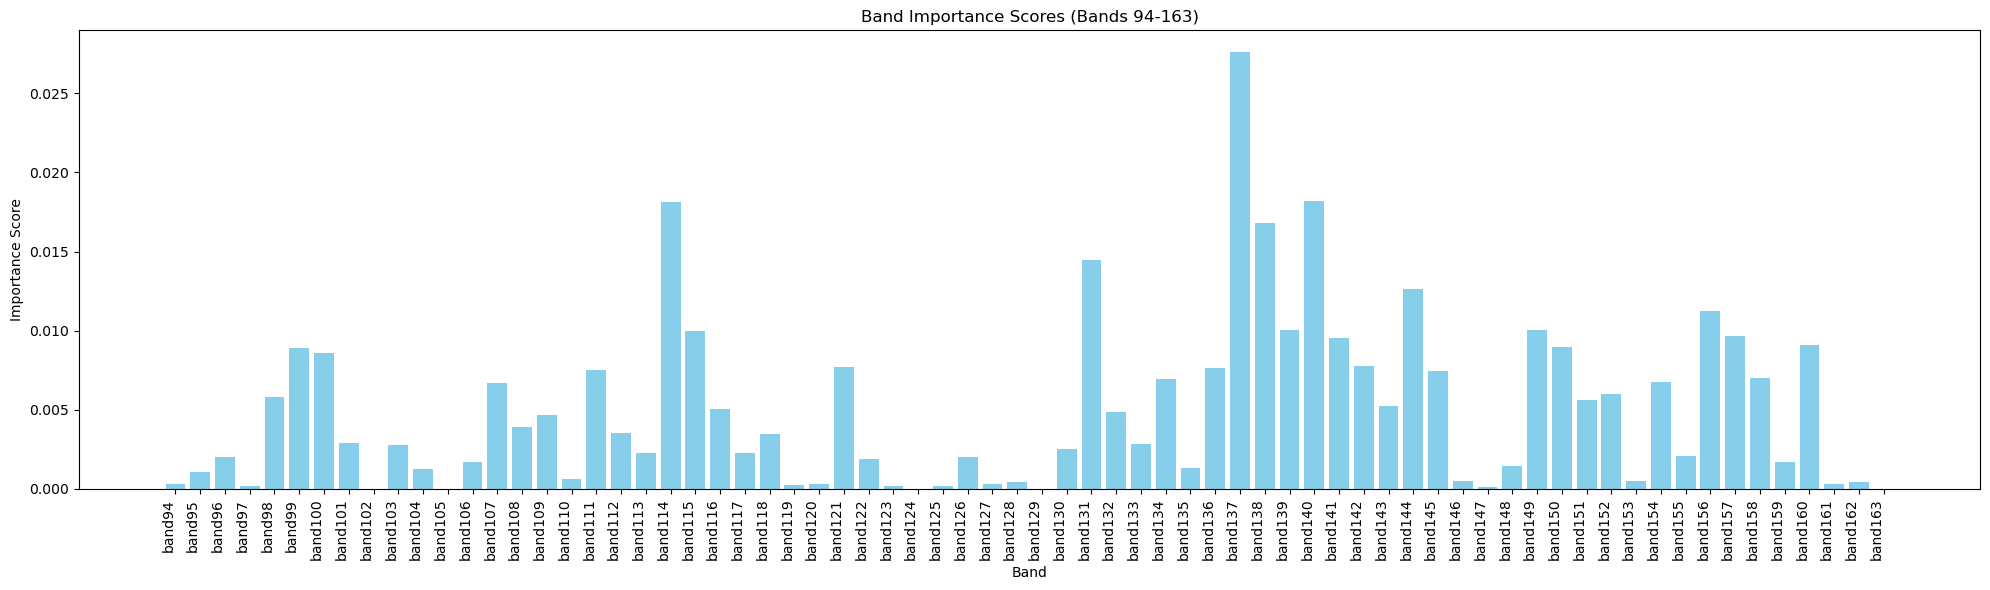

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HISTOGRAM BAND IMPORTANCE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import rasterio as rio
import matplotlib.pyplot as plt

#wawan = r"B:\SEMESTER 10\PENGERJAAN3\roi\destrip"

# Open the raster image
with rio.open(raster) as image:
    bands = image.count

# Define the range of bands you want to include in the histogram
start_band = 94
end_band = 163

# Create a list of band names for the specified range
features = ['band{}'.format(i) for i in range(start_band, end_band+1)]

# Assuming you have calculated the band importances and stored them in 'band_importances'

# Filter band importances for the specified range of bands
band_importances_range = [(b, imp) for b, imp in band_importances if b in features]

# Extract band names and importance scores from the filtered list
bands_range = [band[0] for band in band_importances_range]
importances_range = [band[1] for band in band_importances_range]

# Create a histogram for the specified range of bands
plt.figure(figsize=(20, 6))
plt.bar(bands_range, importances_range, color='skyblue')
plt.xlabel('Band')
plt.ylabel('Importance Score')
plt.title('Band Importance Scores (Bands {}-{})'.format(start_band, end_band))
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save the plot as a high-quality JPG image
plt.savefig(r"B:\SEMESTER 10\AI\band_importance_plot_94_163.jpg", dpi=300)
plt.show()


In [19]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RESHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img[:, :, :].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = grid_search.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (105, 94, 163) to (9870, 163)


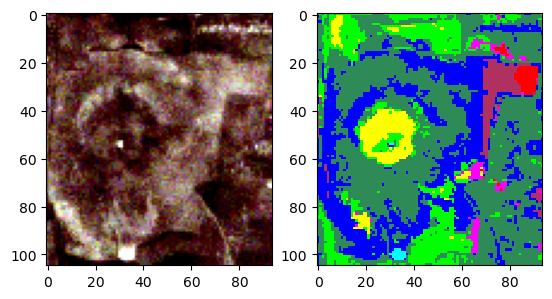

In [20]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ VISUALISASI ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 800))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (255, 255, 255, 255)),  # Nodata
    (1, (255, 0, 0, 255)),  # Forest
    (2, (0, 255, 0, 255)),  # Water
    (3, (0, 0, 255, 255)),  # Herbaceous
    (4, (255, 255, 0, 255)),  # Barren
    (5, (0, 255, 255, 255)),
    (6, (255, 0,255, 255)),
    (7, (176, 48, 96, 255)),
    (8, (46, 139, 87, 255))# Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
     
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

In [21]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ LUAS AREA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have class_prediction and img defined somewhere in your code

# Define the colors dictionary
colors = {
    0: (255, 255, 255, 255),  # Nodata
    1: (255, 0, 0, 255),       # Forest
    2: (0, 255, 0, 255),       # Water
    3: (0, 0, 255, 255),       # Herbaceous
    4: (255, 255, 0, 255),     # Barren
    5: (0, 255, 255, 255),     # Add more classes if needed
    6: (255, 0, 255, 255),
    7: (176, 48, 96, 255),
    8: (46, 139, 87, 255)     # Urban
}

# Count pixels for each class
class_pixels = {}
total_pixels = class_prediction.size

for class_value in np.unique(class_prediction):
    if class_value == 0:  # Skip Nodata
        continue
    class_pixels[class_value] = np.sum(class_prediction == class_value)

# Calculate area occupied in percentage
class_area_percentage = {}
for class_value, pixels in class_pixels.items():
    area_percentage = (pixels / total_pixels) * 100
    class_area_percentage[class_value] = area_percentage

# Display the table
print("Class\tPixels\tArea (%)")
for class_value, pixels in class_pixels.items():
    area_percentage = class_area_percentage[class_value]
    print(f"{class_value}\t{pixels}\t{area_percentage:.2f}%")


Class	Pixels	Area (%)
1	112	1.13%
2	1492	15.12%
3	2537	25.70%
4	474	4.80%
5	28	0.28%
6	161	1.63%
7	341	3.45%
8	4725	47.87%


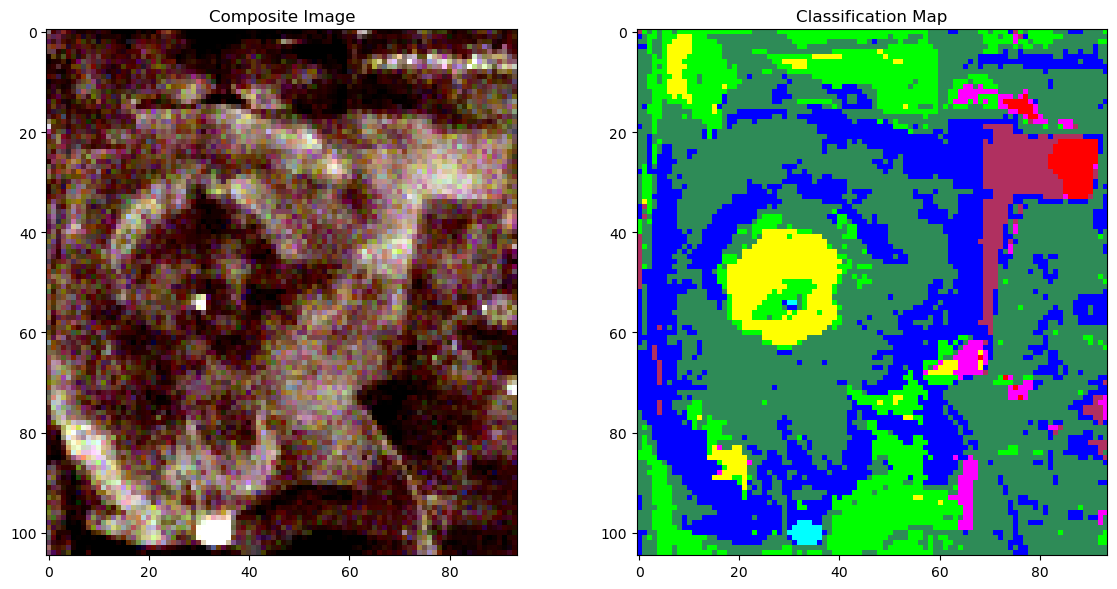

In [22]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ EXPORT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined img543, class_prediction, colors, and cmap as in your code

# Visualize the images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img543)
plt.title('Composite Image')

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.title('Classification Map')

plt.tight_layout()

# Save the visualization to the specified path
save_path = r'B:\SEMESTER 10\AI\classification_visualizationnnn.png'  # Specify the full path here
plt.savefig(save_path, dpi=300)
plt.show()
